
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task ##

Captions need to describe: what is plotted and what is interesting about it

PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.
## respect coding standards ##

The following PEP8 rules are now required

Points will be taken off if they are violated

## problem statement

#### An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.

#### So let's test if the last link holds. If we have data on the energy consumed by a building how well does that relate to the number of units in the building?

#### Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z

#### Either obtain the data through the API or download the csv file, and move it to $PUIDATA  

#### However this datasets does not have the number of units. We can find that in the https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page, Pluto dataset.

#### Reading in the Pluto data for manhattan, which will give me the number of units ber building Manhattan/MNMapPLUTO.shp Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

## data acquisition 
## download, move data to 
 #### PUIDATA and read data. make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.formula.api as smf
import pylab as pl
import os
import geopandas as gpd
import choroplethNYC as cp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Working directory set for homework 10
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
os.chdir(os.getenv("PUIDATA"))
os.getcwd()

'/home/habtemariam/PUIdata'

In [3]:
# download energy consumption file into working directory
!wget https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD -O \
    Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv

--2018-11-28 23:29:23--  https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.68.26, 52.206.140.205, 52.206.140.199
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv’

Energy_and_Water_Da     [       <=>          ]   4.23M  3.02MB/s    in 1.4s    

Last-modified header invalid -- time-stamp ignored.
2018-11-28 23:29:24 (3.02 MB/s) - ‘Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv’ saved [4433512]



In [4]:
# Download pluto data to same location
!curl -O 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0  6560k      0  0:00:01  0:00:01 --:--:-- 6556k


In [5]:
# unpacking the mappluto file; file already extracted;
!unzip mn_mappluto_18v1.zip

Archive:  mn_mappluto_18v1.zip
replace PLUTODD18v1.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. A scatter matrix is a plot of all variables in your data against all other variables: each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).


In [5]:
nrg = pd.read_csv(os.getenv("PUIDATA") + 
                  "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

In [6]:
nrg.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
bsize = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/mn_mappluto_18v1/MNMapPLUTO.shp")

#### NOTE: Edits to the plotting parameters of the scatter matrix below were made with help from the following source: https://stackoverflow.com/questions/32560932/how-to-customize-a-scatter-matrix-to-see-all-titles/32568134

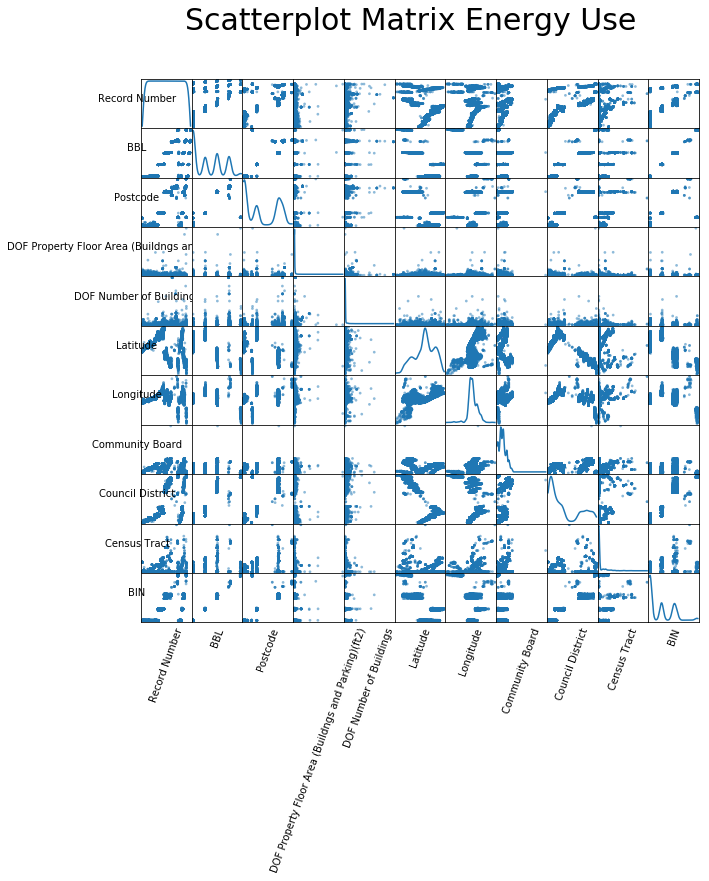

In [8]:
## Create scatter Matrx 
sfig = pd.plotting.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')
pl.suptitle('Scatterplot Matrix Energy Use', fontsize=30)
for ax in sfig.flat:
        # Hide all ticks and labels and rotate the label inspired by A group member;  
        ax.xaxis.label.set_rotation(70)
        ax.yaxis.label.set_rotation(0)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
pl.show();

#### Figure 1: ####
The plot above displays scatter plots of each variable with all other variables within the energy use dataset. Only a few of the pairings appear to have a linear relationship: BIN and BBL, Council District and Latitude, and BBL and Postcode. Additionally, a kernel density estimate plot for each variable is displayed along the diagonal. Most variables do not appear normally distributed, which may be problematic for any parametric tests that require Gaussian-distributed variables.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.


### data cleaning and aggregation ###

### checking the content of the datasets ###
clean up columns I am not using: for my solution, I will keep BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe 

### remove what you do not need¶ ###

In [9]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [10]:
nrg.drop(columns=['Record Number', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status','Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)','DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'], inplace=True)

In [11]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [12]:
bsize.columns.sort_values()

Index(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract201

In [13]:
bsize.drop(columns=['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot','BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract2010','Version',
       'XCoord', 'YCoord', 'YearAlter1', 'YearAlter2','ZMCode',
       'ZipCode', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'ZoneMap'], inplace=True)

In [14]:
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


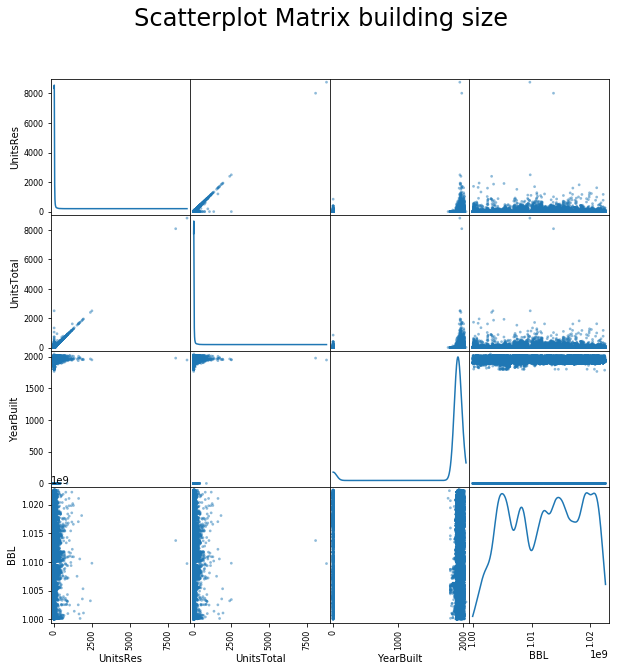

In [15]:
sfig = pd.plotting.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')
pl.suptitle('Scatterplot Matrix building size', fontsize=24)
pl.show;

### Figure 2:####
The plot above shows a scatter plot of each variable with all other variables of the building size dataset. Only UnitsTotal with UnitsRes appears to display a possible linear relationship. However, some relationships may not be well plotted, since extreme outliers distort the plot by expanding the scale. In particular, there appear to be recorded entries of 0 for YearBuilt, which are obvious errors or miscodings of missing information. Along the diagonal, kernel density estimate plots of each variable reveal a similar pattern of possible distortion due to the scaling of the axes, which may require further investigation individually.

### converting the relevant columns to numeric values and throwing away spurious entries
use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [16]:
# conversion for energy data and checking
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10]

(0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 5   NaN
 6   NaN
 7   NaN
 8   NaN
 9   NaN
 Name: Site EUI(kBtu/ft2), dtype: float64, 0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 5    1.002360e+09
 6    1.008370e+09
 7    1.001960e+09
 8    1.022240e+09
 9    1.011270e+09
 Name: BBL, dtype: float64)

In [17]:
#checking conversion
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [18]:
##check conversion worked
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


### merge the 2 datasets
I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [19]:
#merge in a geodataframe for mapping, and if you want in a regular DF for analysis (more portable)
bblnrgdataGPD = pd.merge(bsize, nrg, on='BBL')
bblnrgdata = pd.merge(bsize[['UnitsRes', 'UnitsTotal', 'YearBuilt', 'BBL']], nrg, on='BBL')

In [20]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000


In [21]:
# one final check whether conversion worked
bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')
bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')
bblnrgdataGPD['Site EUI(kBtu/ft2)'] = pd.to_numeric(bblnrgdataGPD['Site EUI(kBtu/ft2)'], errors='coerce')

In [22]:
bblnrgdataGPD.dropna(inplace=True)

In [23]:
# Convert to log space
bblnrgdataGPD['logarea'] = np.log10(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'])
bblnrgdataGPD = bblnrgdataGPD[bblnrgdataGPD['Site EUI(kBtu/ft2)'] >0]
bblnrgdataGPD['lognrg'] = np.log10(bblnrgdataGPD['Site EUI(kBtu/ft2)'])

In [24]:
bblnrgdataGPD['lognrg'].min()

-1.0

In [25]:
print('Logarea max: %f   min: %f' %(bblnrgdataGPD['logarea'].max(), bblnrgdataGPD['logarea'].min()))
print('Logarea max: %f   min: %f' %(bblnrgdataGPD['lognrg'].max(), bblnrgdataGPD['lognrg'].min()))

Logarea max: 6.978437   min: 3.000000
Logarea max: 6.479790   min: -1.000000


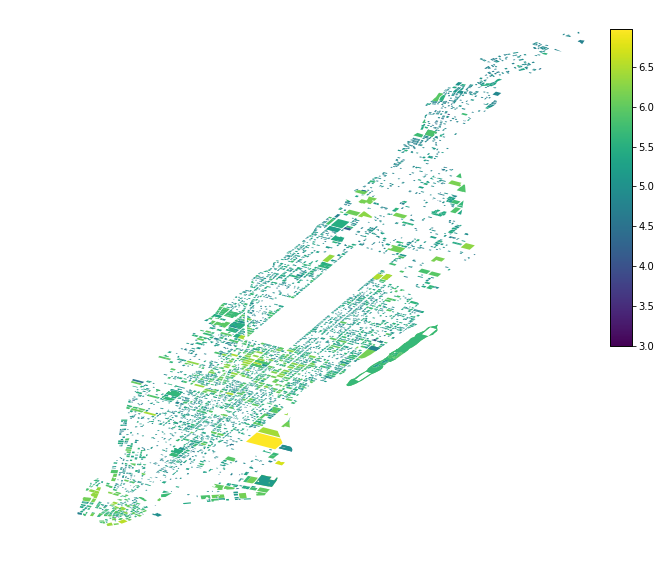

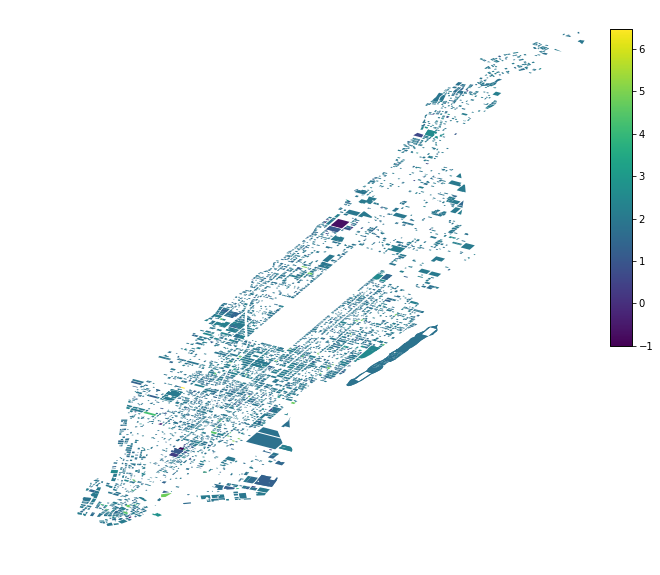

In [26]:
cp.choroplethNYC(bblnrgdataGPD, column = "logarea", cmap ="viridis", side=True)
cp.choroplethNYC(bblnrgdataGPD, column = "lognrg", cmap ="viridis", side=True);

#### Figure 3:#### 
The plots above show maps of the total units for each BBL (left) and the energy usage per BBL (right). In order to show the full range of values clearly, variables were log transformed with base 10. To maintain zero values, one was added to each variable before taking the log. As displayed above, total units extends over a range of 0 to about 4 on the log scale, while EUI extends over about 0 to 6.5 on the log scale. Very low units and very low energy use appear in similar areas, while a range of total units is covered by similar values of EUI at around 2 to 3 kBtu/sq.ft.


### feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model total energy with total units. Create a total energy column from the columns you have. Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.


In [27]:
# multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] * bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
bblnrgdata.dropna()
bblnrgdata.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg
0,50,50,1914,1.007238e+09,68.7,95844.0,6584482.8
1,29,32,1928,1.013850e+09,87.4,206989.0,18090838.6
2,72,72,1923,1.021740e+09,140.4,52920.0,7429968.0
3,107,108,1931,1.008830e+09,96.5,98359.0,9491643.5
4,134,138,1910,1.008570e+09,36.4,154000.0,5605600.0


In [28]:
bblnrgdata.dropna(inplace=True)

In [29]:
bblnrgdata['nrg']
bblnrgdata[bblnrgdata['nrg'] == 0]
bblnrgdata = bblnrgdata[bblnrgdata['nrg'] > 0]

In [30]:
print('minimum building energy value: %f' %(bblnrgdata['nrg'].min()))
print('minimum building energy value: %f' %(bblnrgdata['nrg'].max()))
bblnrgdata['UnitsRes'].max()

minimum building energy value: 5344.000000
minimum building energy value: 350145188000.000000


8764

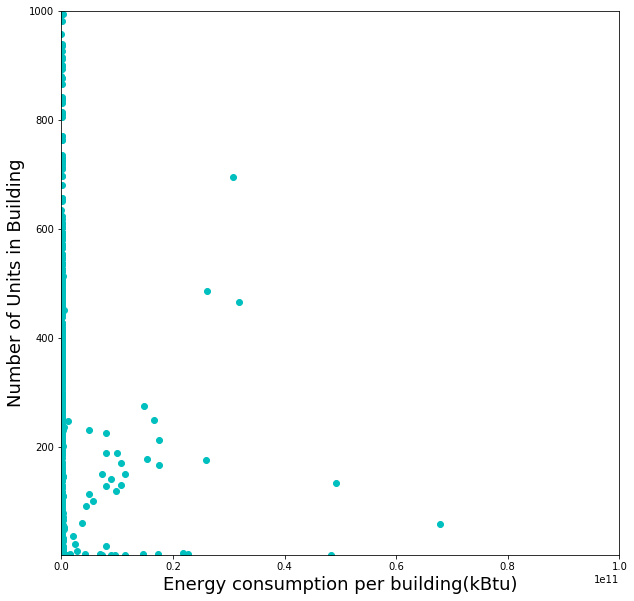

In [31]:
pl.figure(figsize=(10, 10))
pl.plot(bblnrgdata['nrg'], bblnrgdata['UnitsTotal'], 'co')
pl.xlabel('Energy consumption per building(kBtu)', fontsize=18)
pl.ylabel('Number of Units in Building', fontsize=18)
plt.xlim(1000,1e11)
plt.ylim(1,1000);

#### Figure 5: 
The scatter plot above shows total units per building versus total energy consumption of the building. Focusing on units between 0 and 500 and energy consumption between 0 and 5e10 kBtu helps reveal a possible pattern in the data. We can see above that there may be a positive linear relationship between energy consumption and number of units per building.


### The magic of log scales! ###

Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year.

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the order of magnitude)


/home/habtemariam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


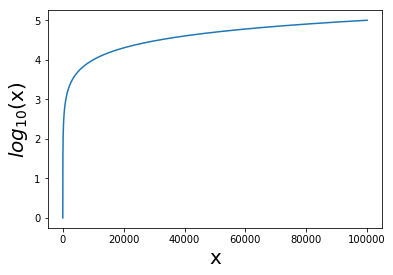

In [32]:
pl.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
pl.xlabel("x", fontsize=20)
pl.ylabel(r"$log_{10}$(x)", fontsize=20);



The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale.

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

log_10(x^y) = y ∙ log_10(x)

And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.



### Plot both NRG vs Units total and Units total vs NRG, both in log space ### 

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything:

energy between (1000,1e10)

units between (1,1000)

You can cut the axis to visualize the data like this, 
#### but you will need to cut the data to remove datapoint outside of this range when you model to get a good model. 
to visualize the data in log scale you can use the dataframe plotting method with the argument loglog=True



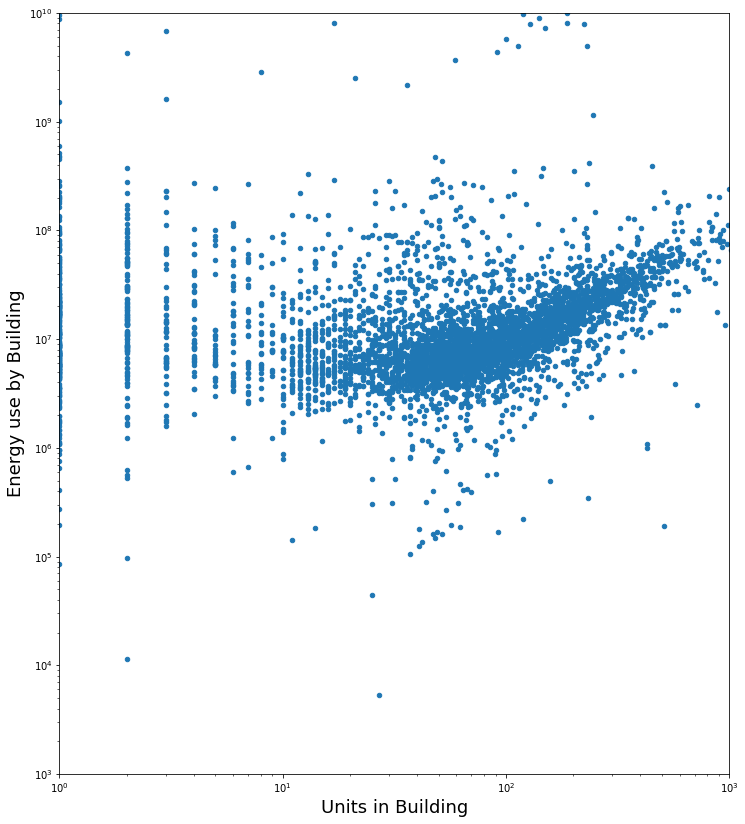

In [33]:
# Plot nrg vs building units
bblnrgdata.plot(x='UnitsTotal', y='nrg', kind='scatter', loglog=True, figsize=(12, 14));
plt.xlabel("Units in Building", fontsize=18)
plt.ylabel("Energy use by Building", fontsize=18)
plt.xlim(1,1000)
plt.ylim(1000,1e10);

#### Figure 6:####
The plot above shows energy consumption per building as a function of the building's total number of units.

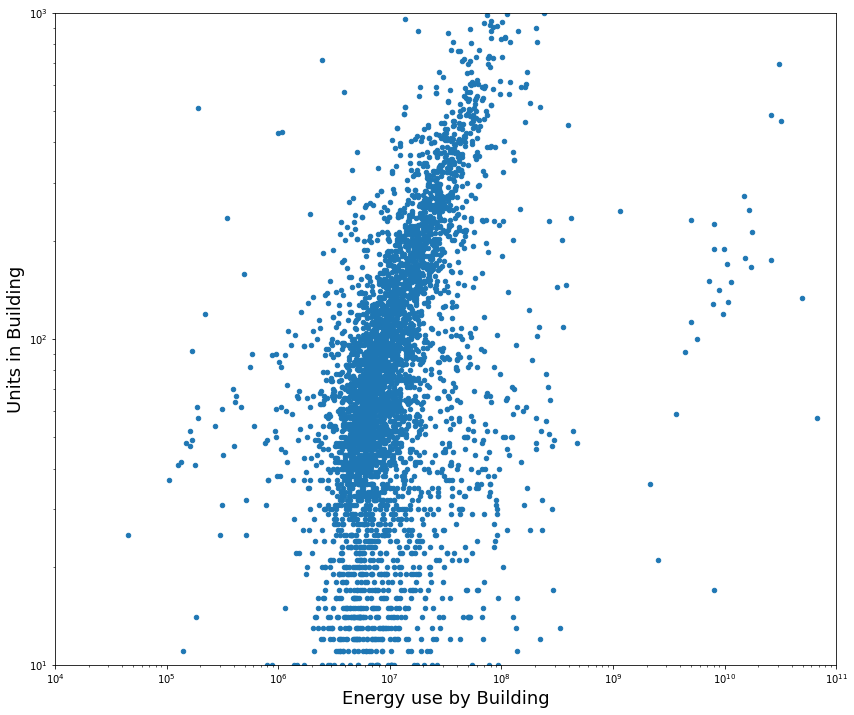

In [35]:
bblnrgdata.plot(x='nrg', y='UnitsTotal', kind='scatter', loglog=True, figsize=(14, 12));
plt.xlabel("Energy use by Building", fontsize=18)
plt.ylabel("Units in Building", fontsize=18)
plt.xlim(10000,1e11)
plt.ylim(10,1000);

#### Figure 7:####
This plot is the same as Figure 6, but with axes switched. This does not make much sense logically.

### Fit the data with a line in log space: ###

#### make sure you print the summary and plot the data and the model ####


### Model NRG as a linear function of number of units in the building

Ciertainly there is a right way to think about this: which is the independent and the dependent variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

answer

However, indulge me and try both models: models (nrg vs units total & units total vs nrg).

    create the models with statsmodels
    print the model summary
    plot the data and the fit
    Check and comment on how the following model diagnostics change:

    R^2 and LogLikelihood

(remember to use only the data in the appropriate range, see the previous step)

#### NOTE: See captions for comparison of R-squared and log likelihood.

In [38]:
#(bblnrgdata.UnitsTotal>0) & (bblnrgdata.UnitsTotal<1000)

In [50]:
bblnrgdataCut = bblnrgdata
bblnrgdataCut = bblnrgdata.loc[(bblnrgdata.UnitsTotal>0) & (bblnrgdata.UnitsTotal<1000)]
bblnrgdataCut = bblnrgdata.loc[(bblnrgdata.nrg>1000) & bblnrgdata.nrg<1e11]

In [62]:
bblnrgdataCut['logNrg'] = log10(bblnrgdata.nrg)  
bblnrgdataCut['logUnits'] = log10(bblnrgdata.UnitsTotal)
bblnrgdataCut['logUnits2'] = bblnrgdataCut['logUnits']**2 

/home/habtemariam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [63]:
bblnrgdataCut = bblnrgdataCut.loc[bblnrgdataCut.logUnits > 0]

In [64]:
# Run linear regression
linmodel_0 = smf.ols(formula='logNrg~logUnits', data=bblnrgdataCut).fit()
print(linmodel_0.summary())

                            OLS Regression Results                            
Dep. Variable:                 logNrg   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     263.4
Date:                Wed, 28 Nov 2018   Prob (F-statistic):           1.16e-57
Time:                        23:44:23   Log-Likelihood:                -3322.5
No. Observations:                4670   AIC:                             6649.
Df Residuals:                    4668   BIC:                             6662.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6535      0.025    260.982      0.0

In [65]:
linmodel_2 = smf.ols(formula='logUnits~logNrg', data=bblnrgdataCut).fit()
print(linmodel_2.summary()) 

                            OLS Regression Results                            
Dep. Variable:               logUnits   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     263.4
Date:                Wed, 28 Nov 2018   Prob (F-statistic):           1.16e-57
Time:                        23:44:23   Log-Likelihood:                -3530.4
No. Observations:                4670   AIC:                             7065.
Df Residuals:                    4668   BIC:                             7078.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0917      0.105      0.872      0.3

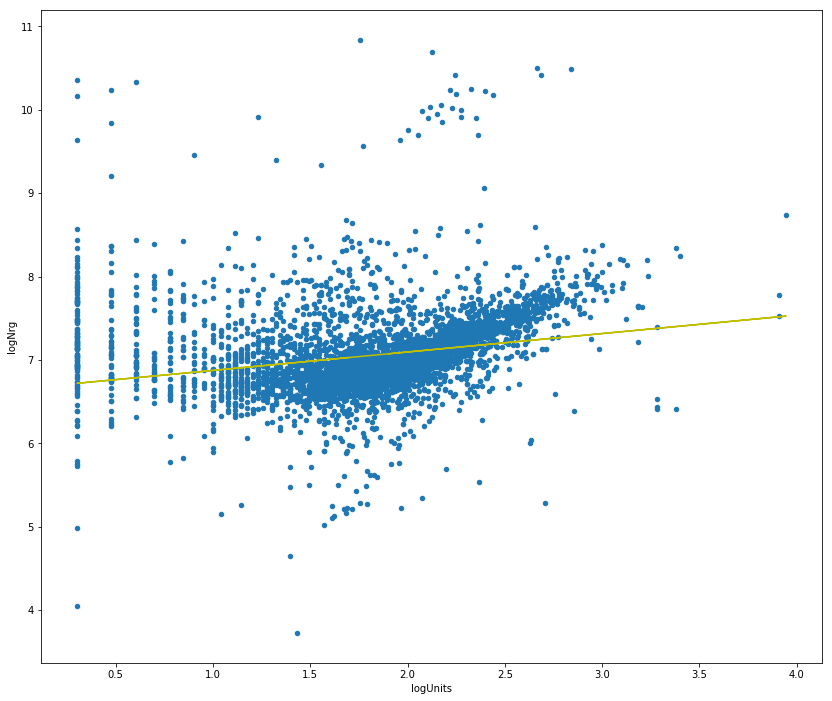

In [66]:
bblnrgdataCut.plot(kind='scatter',x='logUnits',y='logNrg', figsize=(14, 12))
plt.plot(bblnrgdataCut['logUnits'],linmodel_0.predict(bblnrgdataCut),'y-')
plt.show()

#### Figure 8: #### 
The plot above shows the result of a regression of units on energy consumption, fit on the subsetted data. 

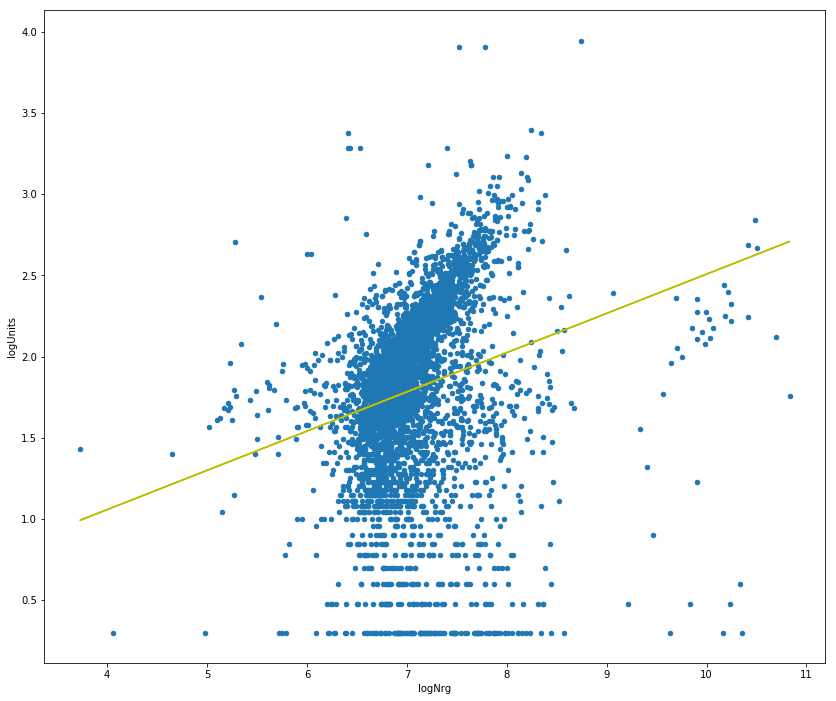

In [67]:
bblnrgdataCut.plot(kind='scatter',x='logNrg',y='logUnits', figsize=(14, 12))
plt.plot(bblnrgdataCut['logNrg'],linmodel_2.predict(bblnrgdataCut),'y-')
plt.show()

In [68]:
linmodel_3= smf.ols(formula='logNrg~logUnits2+logUnits', data=bblnrgdataCut).fit()
print(linmodel_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 logNrg   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     503.5
Date:                Wed, 28 Nov 2018   Prob (F-statistic):          9.64e-199
Time:                        23:44:26   Log-Likelihood:                -2994.4
No. Observations:                4670   AIC:                             5995.
Df Residuals:                    4667   BIC:                             6014.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5983      0.043    177.492      0.0

In [69]:
bblnrgdataCut.sort_values("logUnits", inplace=True)

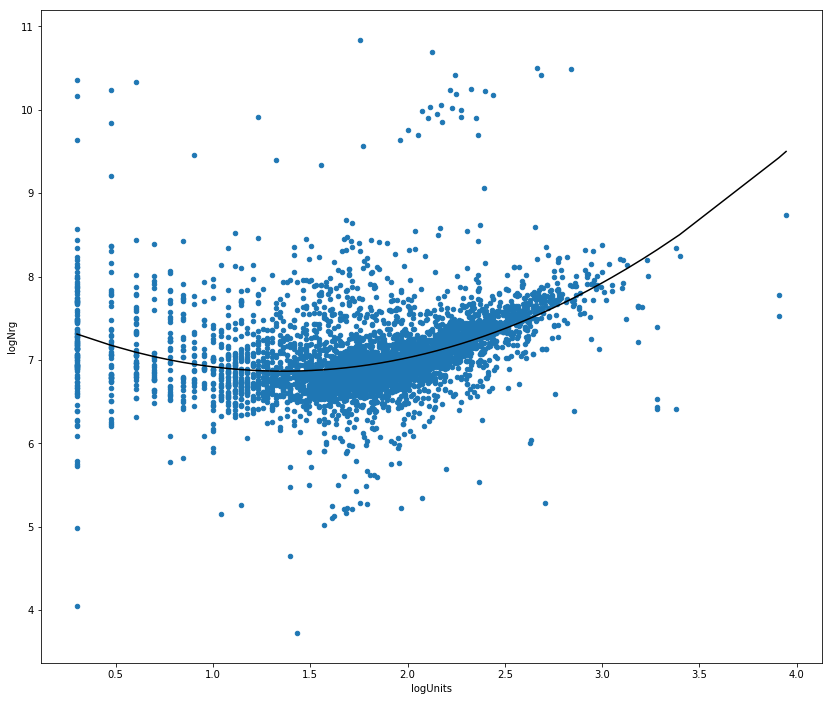

In [71]:
bblnrgdataCut.plot(kind='scatter',x='logUnits',y='logNrg', figsize=(14, 12))
plt.plot(bblnrgdataCut['logUnits'],linmodel_3.predict(bblnrgdataCut),'k')
plt.show()

In [74]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    return sum((model - data)**2 / errors**2)

In [75]:
error1 = np.sqrt(bblnrgdataCut['Site EUI(kBtu/ft2)'])
error2 = np.sqrt(bblnrgdataCut['Reported Property Floor Area (Building(s)) (ft²)'])
errorsnrg = np.sqrt(error1**2 + error2**2)
bblnrgdataCut['errorsnrg'] = errorsnrg / bblnrgdataCut['nrg'] *np.log(10)

In [76]:
errorsunits = np.sqrt(bblnrgdataCut['logUnits'])
bblnrgdataCut['errorsunits'] = errorsunits / (bblnrgdataCut.logUnits * np.log(10))
bblnrgdataCut.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg,logNrg,logUnits,logUnitsSq,logUnits2,errorsnrg,errorsunits
227,0,2,1900,1.000780e+09,39.5,115488.0,4561776.0,6.659134,0.30103,0.090619,0.090619,0.000172,0.791552
5590,0,2,1968,1.011370e+09,141.4,365000.0,51611000.0,7.712742,0.30103,0.090619,0.090619,0.000027,0.791552
6338,0,2,1921,1.006008e+09,88.6,623027.0,55200192.2,7.741941,0.30103,0.090619,0.090619,0.000033,0.791552
2938,0,2,1926,1.013770e+09,123.5,69725.0,8611037.5,6.935055,0.30103,0.090619,0.090619,0.000071,0.791552
5577,0,2,1915,1.001760e+09,40.0,60348.0,2413920.0,6.382723,0.30103,0.090619,0.090619,0.000234,0.791552


The largest error bar is for


,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg,logNrg,logUnits,logUnitsSq,logUnits2,errorsnrg,errorsunits
3313,27,27,1909,1.019900e+09,0.1,53440.0,5344.0,3.727866,1.431364,2.048802,2.048802,0.099605,0.363002


/home/habtemariam/anaconda3/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:158: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  warnings.warn('There are no gridspecs with layoutboxes. '
/home/habtemariam/anaconda3/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:158: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  warnings.warn('There are no gridspecs with layoutboxes. '
/home/habtemariam/anaconda3/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:158: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  warnings.warn('There are no gridspecs with layoutboxes. '


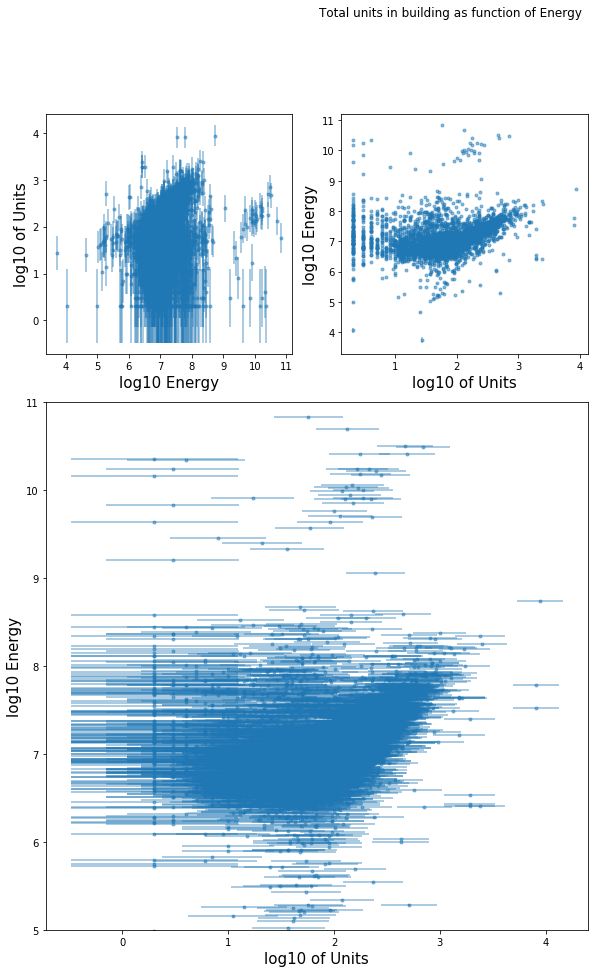

In [77]:
import matplotlib.gridspec as gridspec
#I could also include errors for number of units
fig2 = plt.figure(constrained_layout=True, figsize=(15,15))

gs1 = gridspec.GridSpec(3, 3, figure=fig2)
gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal), 
            yerr=bblnrgdataCut.errorsunits, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
ax1.set_xlabel("log10 Energy", fontsize=15)
pl.suptitle("Total units in building as function of Energy")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg,
           xerr=bblnrgdataCut.errorsunits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
bblnrgdataCut[bblnrgdataCut.errorsnrg == bblnrgdataCut.errorsnrg.max()]

Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see, and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it.

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved.

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.


In [81]:
dof = 2
print ("degrees of freedom:" , dof)

degrees of freedom: 2


In [ ]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict()) / float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))